# Assignment: 2D radioactive lighthouse location using MCMC

As before, a radioactive source that emits gamma rays randomly in time but uniformly in angle is placed at $(x_0, y_0)$.  The gamma rays are detected on the $x$-axis and these positions are saved, $x_k$, $k=1,2,\cdots, N$.  Given these observed positions, the problem is to estimate the location of the source.

Unlike before, we will not assume that $y_0$ is known. Your task is to estimate both $x_0$ and $y_0$.  Since we are using Bayesian methods, this means finding the joint posterior for $x_0$ and $y_0$, given the data on where the gamma rays were detected.

You will combine the results and Python code from the `radioactive_lighthouse_exercise.ipynb` and `parameter_estimation_Gaussian_noise.ipynb` notebooks, sampling the posterior using `emcee` and plotting it using `corner`.


## Learning goals:

* Be able to re-use markdown and Python from existing notebooks to perform similar tasks (even if not understanding all details); e.g., generating data, sampling via MCMC, making plots.
* Successfully apply the basic ideas of Bayesian statistics: Bayes theorem, priors, sampling of posteriors.
* Successfully analyze results (with hints).
* Try out markdown.

Note: you shouldn't need to recalculate anything; focus on the notebook ingredients.

## Expressions

The posterior we want is:

$$ p(x_0, y_0 | \{x_k\}, I) \overset{?}{=}
$$

*Using $\LaTeX$, fill in the right side of the equation for Bayes' rule as it applies in this case.* 

$\color{red}{\text{Solution}}$
$$ p(x_0, y_0 | \{x_k\}, I) = \frac{p( \{x_k\}|x_0,y_0, I)\times p(x_0,y_0|I)}{p(\{ x_k \}|I)}
$$

*Then add below the expression for the likelihood in this case (replace the dots with the correct form and fill in the right side):*

$$  p(\{x_k\} | \cdots) \overset{?}{=}
$$
$\color{red}{\text{Solution}}$
$$ p( \{x_k\}|x_0,y_0, I) = \frac{y_0}{\pi}\{y_0^2+(x_k-x_0)^2\}
$$

*Describe in words what you will use for the prior:*

$\color{red}{\text{Solution}}$

For the prior, we can use an uniform distribution, $p(x_0,y_0) = \frac{1}{(x_{max}-x_{min})}\times\frac{1}{(y_{max}-y_{min})}$, where we have assumes that the x cordinate and y coordinate are independently distributed, with some uniform distribution between the range $\{ x_{min},x_{max}\}$ and $\{y_{min},y_{max}\}$. 

*Do you need to find an expression for the denominator pdf?  Explain.*

$\color{red}{\text{Solution}}$

We do not need to find an expression for the denominater, as it is an overall constant on normalization that can be scaled away


## Python imports

You will need to import emcee and corner.  The best way to do this is to follow the instructions for making an environment (see Carmen page).  An alternative is to install them separately using (at the command line):

`conda install -c astropy emcee`

`conda install -c astropy corner`

In [1]:
# Copy to here all of the Python imports you think will be relevant

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from scipy.stats import cauchy, uniform
import seaborn as sns
sns.set()      
sns.set_context("talk")
from scipy import stats
import emcee
import corner

## Generating the data

Copy-and-paste here the code from `radioactive_lighthouse_exercise.ipynb` used to generate the $x_k$ points.  Note that you have control over where the true position is but also the size of the dataset.  You will want to adjust both later. It is recommended to add the code that plots the distribution of the data (to verify it is the same as before), but this is not required.

In [2]:
# Add code here to generate the dataset.  Start with 500 points.


def lighthouse_data_generate(x0_true,y0_true,num_pts):
    
    # Note theta0[0] = x0, theta0[1] = y0 in our convention
    
    x_pts = np.arange(num_pts)
    theta_dist = uniform(-np.pi/2., np.pi)
    x_k = x0_true + y0_true * np.tan(theta_dist.rvs(num_pts))

    
    
    # Make some plots!
    fig = plt.figure(figsize=(15,5))

    # First plot all the points, letting it autoscale the counts
    ax_1 = fig.add_subplot(1,3,1)
    ax_1.scatter(x_pts, x_k)  

    # Repeat but zoom in to near the origin
    ax_2 = fig.add_subplot(1,3,2)
    ax_2.scatter(x_pts, x_k)
    ax_2.set_ylim(-10.,10.)

    # Finally make a zoomed-in histogram
    ax_3 = fig.add_subplot(1,3,3)
    out = ax_3.hist(x_k, bins=np.arange(-10., 10., 0.2))

    # Print out the numerical limits (max and min)
    print('maximum = ', np.amax(x_k))
    print('minimum = ', np.amin(x_k))

    fig.tight_layout()
    
    return x_k


#print(D)

## PDFs for applying Bayes' rule

*Adapt code from the two notebooks to express the logarithms of the prior, likelihood, and posterior for this case.*

In [3]:
# Add code for the log_prior, log_likelihood, and log_posterior

min_theta=np.array([-5,0.01])
max_theta=np.array([5,5])
volume_theta=np.prod(max_theta-min_theta)

def log_prior(theta):
    '''Log prior for parameter array theta'''
    assert len(theta)==2, "Parameter vector must have length two."
    # flat prior 
    if np.logical_and(min_theta<=theta, theta<=max_theta).all(): 
        return np.log(1/volume_theta)
    else:
        return -np.inf

def log_likelihood(theta, dist_pts):
    
    x0 = theta[0]
    y0 = theta[1]
    
    '''Log likelihood for data dist_pts given parameter array theta'''
    L_pts = -np.log(y0**2 + (dist_pts - x0)**2) + np.log(np.abs(y0))
    return sum(L_pts)   #-np.amax(L_pts)

def log_posterior(theta, dist_pts):
    '''Log posterior for data X_k(dist_pts) given parameter array theta'''
    
    log_prior_pts = log_prior(theta)
    log_L_pts = log_likelihood(theta, dist_pts)
    #log_L_pts -= np.amax(log_L_pts)  # subtract maximum of log likelihood
    
    return log_prior_pts + log_L_pts


## Run MCMC

*Copy code to run `emcee` and make any necessary changes.*

In [4]:
# Add the code to run emcee

def run_mcmc(X0_true,Y0_true,num_pts,ndim,nwalkers,nbrun,nsteps):
    

    D = lighthouse_data_generate(X0_true,Y0_true,num_pts)

# we'll start at random locations within the prior volume
    starting_guesses = min_theta + \
                   (max_theta - min_theta) * np.random.rand(nwalkers,ndim)

    print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[D])

# "burn-in" period; save final state and then reset
    state = sampler.run_mcmc(starting_guesses, nburn)
    sampler.reset()

# sampling period
    sampler.run_mcmc(state, nsteps)

    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)"
                .format(np.mean(sampler.acceptance_fraction),nwalkers*nsteps))

# discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
    samples = sampler.chain.reshape((-1, ndim))
#print(samples.shape)
    emcee_trace = sampler.chain[:, :, :].reshape(-1, ndim).T
#print(emcee_trace) 
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(emcee_trace[0], emcee_trace[1], ',k', alpha=0.1);

    fig, ax = plt.subplots(ndim, sharex=True,figsize=(5,5))
    for i in range(ndim):
        ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);

    return samples

## Generate figures

Note: you do not need to do the maximum likelihood estimates that were added to the corner plot for the Gaussian noise case.  You can skip that part of the code.

maximum =  92.97368804969324
minimum =  -198.7022870171141
MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers
Mean acceptance fraction: 0.717 (in total 250000 steps)


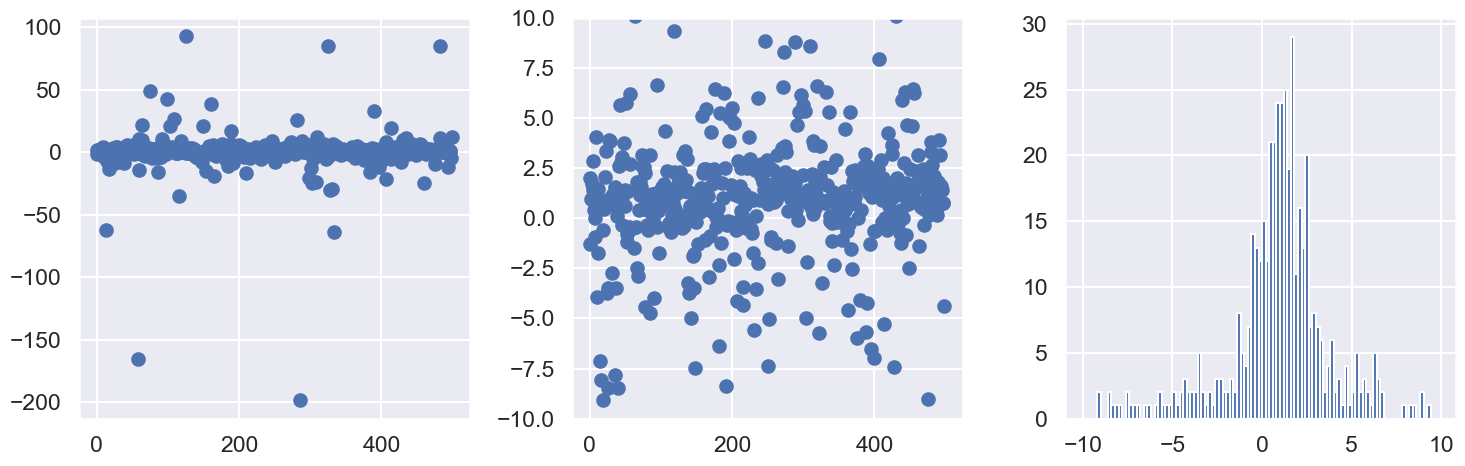

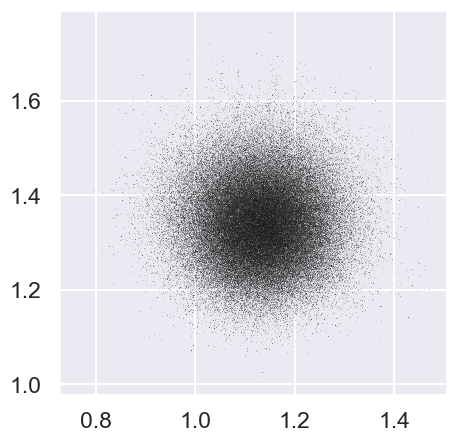

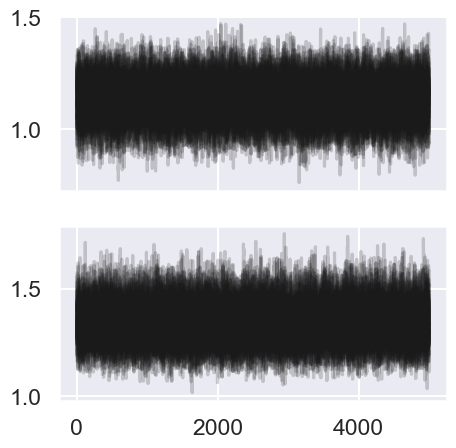

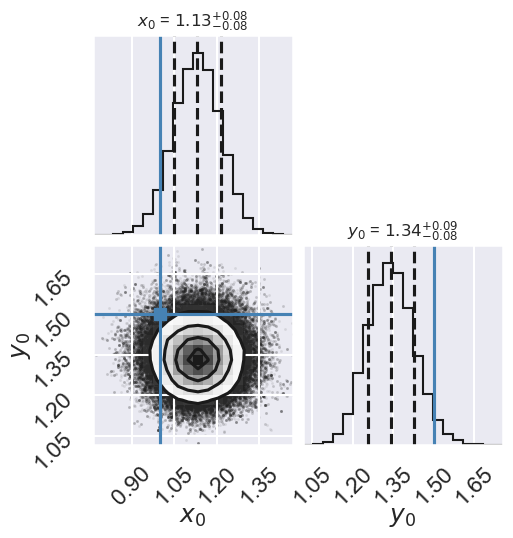

In [5]:
X0_true = 1
Y0_true = 1.5

num_pts = 500
ndim = 2  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 2000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take

samples = run_mcmc(X0_true,Y0_true,num_pts,ndim,nwalkers,nburn,nsteps)

# Add the code to make a corner plot
fig = corner.corner(samples, labels=["$x_0$", "$y_0$"],
                    truths=[X0_true, Y0_true],quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12})

## Analysis

Summarize the results for the following investigations.  You can simply add to the cell containing the questions or else start new cells.

1. *Run the notebook 10 times (which will generate 10 different sets of random data).  Record the values of $x_0$ and $y_0$ and their uncertainties given on the corner plot for each run.  Is the actual spread of values consistent with the given uncertainties?* <br/><br/>



In [2]:
%%html

<style> 
 table { width:90% !important; }
 table td, table th, table tr {border: 2px solid black !important; 
                               text-align:center !important;
                               font-size: 15px;}
</style>

$\color{red}{\text{Solution}}$
$X_0$(true) = -1
$Y_0$(true) = 0.5

Using Nburn = 2000, NSteps = 5000, 50 walkers, 500 $x_k$ points

|     Run no    | $x_0$ | +$\Delta x_0$,-$\Delta x_0$ | $y_0$ | +$\Delta y_0$,-$\Delta y_0$ |
| :-------------: | :----------: | :-----------: | :-----------: | :-------------: | 
|  1           |   $-0.95$     |    $0.03,-0.03$    |    $0.49$   |   $0.03, -0.03$     |
|  2           |   $-0.97$     |    $0.04,-0.04$    |    $0.55$   |   $0.04,-0.03$     | 
|  3           |   $-0.99$     |    $0.03,-0.03$    |    $0.53$   |   $0.03,-0.03$     |
|  4          |   $-0.96$     |    $0.03,-0.03$    |    $0.53$   |   $0.03,-0.03$     | 
|  5          |   $-0.97$     |    $0.03,-0.03$    |    $0.56$   |   $0.04,-0.03$     |  
|  6         |   $-1.02$     |    $0.03,-0.03$    |    $0.50$   |   $0.03,-0.03$     | 
|7           |   $-0.98$     |    $0.03,-0.03$    |    $0.49$   |   $0.03,-0.03$      |
|8           |   $-0.97$     |    $0.03,-0.03$    |   $0.47$    |   $0.03,-0.03$      |
|9           |   $-1.02$     |    $0.03,-0.03$    |   $0.49$    |   $0.03,-0.03$      |
|10.         |   $-0.99$     |    $0.03,-0.03$    |   $0.48$    |   $0.03,-0.03$      |


2. *Increase the number of data points by a factor of 10.  By how much does the width of the posterior shrink?  Is this expected?* <br/><br/>

$\color{red}{\text{Solution}}$

$X_0$(true) = -1
$Y_0$(true) = 0.5

Using Nburn = 2000, NSteps = 5000, 50 walkers

|     No of $x_k$ points | $x_0$ | +$\Delta x_0$,-$\Delta x_0$ | $y_0$ |+$\Delta y_0$,-$\Delta y_0$ |
| :-------------: | :----------: | :-----------: | :-----------: | :-------------: | 
|  50           |   $-1.00$     |    $0.09,-0.08$    |    $0.43$   |   $0.09, -0.08$     |
|  500           |   $-1.04$     |    $0.03,-0.03$    |    $0.51$   |   $0.03,-0.03$     | 
|  5000           |   $-0.99$     |    $0.01,-0.01$    |    $0.51$   |   $0.01,-0.01$     |
|  50000          |   $-1.00$     |    $0.00,-0.00$    |    $0.50$   |   $0.00,-0.00$     | 

For $N(x_{k})$ = 50000, the uncertainty in both $x_0$ and $y_0$ were smaller than what corner could calculate up to 2 significant digits.

This is expected, as with more number of data points, there are more terms to sum in the log likelihood function, hence, oscillations in the posterior probability due to moving around in $x_0,y_0$ plane during the MCMC are "cancelled" out by a large number of terms in the sum. Thus the uncertainties decrease monotonically when number of data points are increased.


3. *What does increasing the number of MC steps per walker do?* <br/><br/>

$\color{red}{\text{Solution}}$

$X_0$(true) = -1
$Y_0$(true) = 0.5

Using Nburn = 2000,  50 walkers, 500 $x_k$ points

|     NSteps per walker    | $x_0$ | +$\Delta x_0$,-$\Delta x_0$ | $y_0$ | +$\Delta y_0$,-$\Delta y_0$ | $\sqrt{(x_0-x_0^{true})^2+(y_0-y_0^{true})^2}$ |
| :-------------: | :----------: | :-----------: | :-----------: | :-------------: | :-------------: |
|  50           |   $-0.97$     |    $0.03,-0.03$    |    $0.48$   |   $0.03, -0.03$     | 0.036|
|  100           |   $-1.03$     |    $0.03,-0.03$    |    $0.48$   |   $0.03,-0.03$     | 0.036|
|  500           |   $-1.02$     |    $0.03,-0.03$    |    $0.44$   |   $0.03,-0.03$     | 0.063|
|  1000          |   $-0.98$     |    $0.03,-0.03$    |    $0.51$   |   $0.03,-0.03$     | 0.022|
|  5000          |   $-1.01$     |    $0.03,-0.03$    |    $0.52$   |   $0.03,-0.03$     | 0.022|

Using Nburn = 500,  50 walkers, 500 $x_k$ points

|     NSteps per walker    | $x_0$ | +$\Delta x_0$,-$\Delta x_0$ | $y_0$ | +$\Delta y_0$,-$\Delta y_0$ |$\sqrt{(x_0-x_0^{true})^2+(y_0-y_0^{true})^2}$ |
| :-------------: | :----------: | :-----------: | :-----------: | :-------------: | :-------------: |
|  50           |   $-1.00$     |    $0.03,-0.03$    |    $0.43$   |   $0.03, -0.03$     | 0.07|
|  100           |   $-0.96$     |    $0.03,-0.03$    |    $0.57$   |   $0.03,-0.03$     | 0.08|
|  500           |   $-1.03$     |    $0.03,-0.03$    |    $0.50$   |   $0.03,-0.03$     | 0.03|
|  1000          |   $-1.02$     |    $0.03,-0.03$    |    $0.49$   |   $0.03,-0.03$     | 0.022|
|  5000          |   $-0.98$     |    $0.03,-0.03$    |    $0.53$   |   $0.03,-0.03$     | 0.036|

Using Nburn = 100,  50 walkers, 500 $x_k$ points

|     NSteps per walker    | $x_0$ | +$\Delta x_0$,-$\Delta x_0$ | $y_0$ | +$\Delta y_0$,-$\Delta y_0$ |$\sqrt{(x_0-x_0^{true})^2+(y_0-y_0^{true})^2}$ |
| :-------------: | :----------: | :-----------: | :-----------: | :-------------: | :-------------: 
|  50           |   $-0.92$     |    $0.03,-0.03$    |    $0.53$   |   $0.03, -0.03$     |0.085|
|  100           |   $-0.95$     |    $0.03,-0.03$    |    $0.57$   |   $0.03,-0.03$     |0.086| 
|  500           |   $-1.01$     |    $0.03,-0.03$    |    $0.45$   |   $0.03,-0.03$     |0.051|
|  1000          |   $-0.97$     |    $0.03,-0.03$    |    $0.48$   |   $0.03,-0.03$     |0.036| 
|  5000          |   $-1.03$     |    $0.03,-0.03$    |    $0.48$   |   $0.03,-0.03$     |0.036|


We choose 3 different burn step size, to see if the walkers are all thermalizing before the measurement starts. Since the errobars in estimation of $x_0$ and $y_0$ are fixed by the number of data points $x_k$, the error bars are constant. Note that however for 100 burn in steps, the statistics get better as the measurement sweeps are increased. However, once the number of burn steps are sufficiently large (2000), the error bars or uncertainties oscillate with increasing measurement sweeps, showing that the system may have reached ergodicity.

4. *Try changing `x0_true` and `y0_true`.  Does it still work?* <br/><br/>

$\color{red}{\text{Solution}}$

$X_0$(true) = 1
$Y_0$(true) = 1.5

Using Nburn = 500,  50 walkers, 500 $x_k$ points

|     NSteps per walker    | $x_0$ | +$\Delta x_0$,-$\Delta x_0$ | $y_0$ | +$\Delta y_0$,-$\Delta y_0$ | $\sqrt{(x_0-x_0^{true})^2+(y_0-y_0^{true})^2}$ |
| :-------------: | :----------: | :-----------: | :-----------: | :-------------: | :-------------: |
|  50           |   $0.95$     |    $0.10,-0.10$    |    $1.47$   |   $0.09, -0.09$     | 0.058|
|  100           |   $0.98$     |    $0.09,-0.09$    |    $1.49$   |   $0.10,-0.09$     | 0.022|
|  500           |   $1.13$     |    $0.09,-0.09$    |    $1.56$   |   $0.10,-0.09$     | 0.143|
|  1000          |   $0.92$     |    $0.09,-0.09$    |    $1.49$   |   $0.09,-0.09$     | 0.081|
|  5000          |   $1.16$     |    $0.09,-0.09$    |    $1.50$   |   $0.10,-0.09$     | 0.160|

Using Nburn = 2000,  50 walkers, 500 $x_k$ points

|     NSteps per walker    | $x_0$ | +$\Delta x_0$,-$\Delta x_0$ | $y_0$ | +$\Delta y_0$,-$\Delta y_0$ | $\sqrt{(x_0-x_0^{true})^2+(y_0-y_0^{true})^2}$ |
| :-------------: | :----------: | :-----------: | :-----------: | :-------------: | :-------------: |
|  50           |   $0.89$     |    $0.10,-0.09$    |    $1.46$   |   $0.10, -0.08$     | 0.117|
|  100           |   $0.92$     |    $0.11,-0.10$    |    $1.64$   |   $0.11,-0.10$     | 0.161|
|  500           |   $0.95$     |    $0.10,-0.10$    |    $1.54$   |   $0.10,-0.09$     | 0.064|
|  1000          |   $1.04$     |    $0.09,-0.10$    |    $1.52$   |   $0.10,-0.09$     | 0.045|
|  5000          |   $1.01$     |    $0.09,-0.09$    |    $1.52$   |   $0.10,-0.09$     | 0.022|

Error bars are larger in this case, however note that the error bars, as shown by $\sqrt{(x_0-x_0^{true})^2+(y_0-y_0^{true})^2}$, are fluctuating with increasing Nsteps, for lower burn number(500), they are more stabilized and decrese with Nsteps for larger burn number(2000), showing that the system takes larger time to thermalize for this choice of $x_0^{true},y_0^{true}$